## Loading the needed libraries

In [ ]:
!pip install -U datasets huggingface_hub xformers bitsandbytes transformers accelerate peft dadaptation prodigyopt torchvision python-slugify
!pip install git+https://github.com/huggingface/diffusers.git -q
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/advanced_diffusion_training/train_dreambooth_lora_sdxl_advanced.py

In [ ]:
from PIL import Image
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from slugify import slugify
from kaggle_secrets import UserSecretsClient
from huggingface_hub import whoami,hf_hub_download, login
from pathlib import Path
from IPython.display import display, Markdown
import torch
import gc
from diffusers import DiffusionPipeline, StableDiffusionXLPipeline
from diffusers.models import AutoencoderKL

## Exploring the dataset & Visualization

Repo card metadata block was not found. Setting CardData to empty.


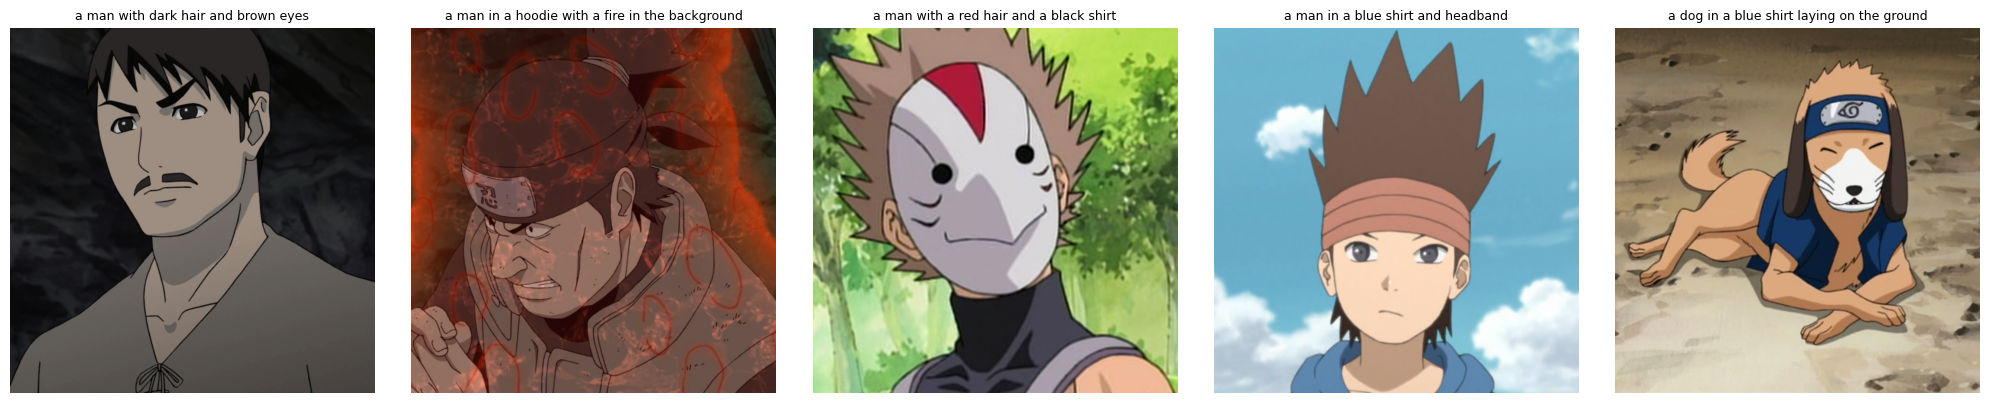

In [ ]:
# Function to create image grid
def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# Load the Naruto dataset from Hugging Face
ds = load_dataset("lambdalabs/naruto-blip-captions")

# Extract images and captions from the dataset
num_imgs_to_preview = 5

# The images are stored in the 'image' column, captions in 'text'
imgs = []
captions = []
for i in range(num_imgs_to_preview):
    img = ds['train'][i]['image']
    caption = ds['train'][i]['text']
    imgs.append(img)
    captions.append(caption)

# Create a figure with subplots for better caption placement
fig = plt.figure(figsize=(20, 5))
for i in range(num_imgs_to_preview):
    # Create subplot
    ax = fig.add_subplot(1, num_imgs_to_preview, i+1)

    # Display image
    ax.imshow(imgs[i])
    ax.axis('off')

    # Add caption (truncated if too long)
    if len(captions[i]) > 80:
        short_caption = captions[i][:77] + "..."
    else:
        short_caption = captions[i]

    ax.set_title(short_caption, fontsize=9, wrap=True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

# Prep for training

In [ ]:
!accelerate config default

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [ ]:
# Logging into huggingface hub
user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
login(HF_TOKEN)

In [ ]:
#Specify the model name and output directory
model_name = "diffusers-finetuned-naruto"
output_dir = slugify(model_name)

In [ ]:
# Setting the rank for LoRA
rank = 4

In [9]:
!accelerate launch train_dreambooth_lora_sdxl_advanced.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="lambdalabs/naruto-blip-captions" \
  --output_dir="$output_dir" \
  --instance_prompt="a naruto anime character"\
  --caption_column="text" \
  --image_column="image" \
  --mixed_precision="fp16" \
  --resolution=256 \
  --train_batch_size=1 \
  --repeats=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --learning_rate=1.0 \
  --text_encoder_lr=1.0 \
  --adam_beta2=0.99 \
  --optimizer="prodigy"\
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --rank="$rank" \
  --max_train_steps=500 \
  --checkpointing_steps=1000 \
  --seed="0" \
  --push_to_hub

2025-05-14 18:01:08.377960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 18:01:08.378066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747245668.402235     622 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747245668.402235     623 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747245668.409223     623 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747245668.409328     622 cuda_blas.cc:1

In [ ]:
# Ensure the model is pushed to the hub
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

link_to_model = f"https://huggingface.co/{repo_id}"

display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/AbdelrahmanGalhom/diffusers-finetuned-naruto

# Inference

In [ ]:
def free_cuda_memory():
    # Clear PyTorch cache
    torch.cuda.empty_cache()
    
    # Run garbage collector
    gc.collect()
    
    # Print memory stats
    if torch.cuda.is_available():
        print(f"CUDA memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"CUDA memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    else:
        print("CUDA not available")

# Delete specific model variables if they exist
try:
    # Check if 'pipe' exists in globals
    if 'pipe' in globals():
        del pipe
        print("Deleted pipeline model")

except Exception as e:
    print(f"Error while deleting variables: {e}")

# Free memory
free_cuda_memory()

CUDA memory allocated: 0.00 GB
CUDA memory reserved: 0.00 GB


In [ ]:
# Load base model with optimized VAE
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
).to("cuda")

# Load LoRA weights
pipe.load_lora_weights(
    repo_id, 
    weight_name="pytorch_lora_weights.safetensors"
)

# Enable the LoRA layers
pipe.fuse_lora()  #fuse the LoRA layers for faster inference


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

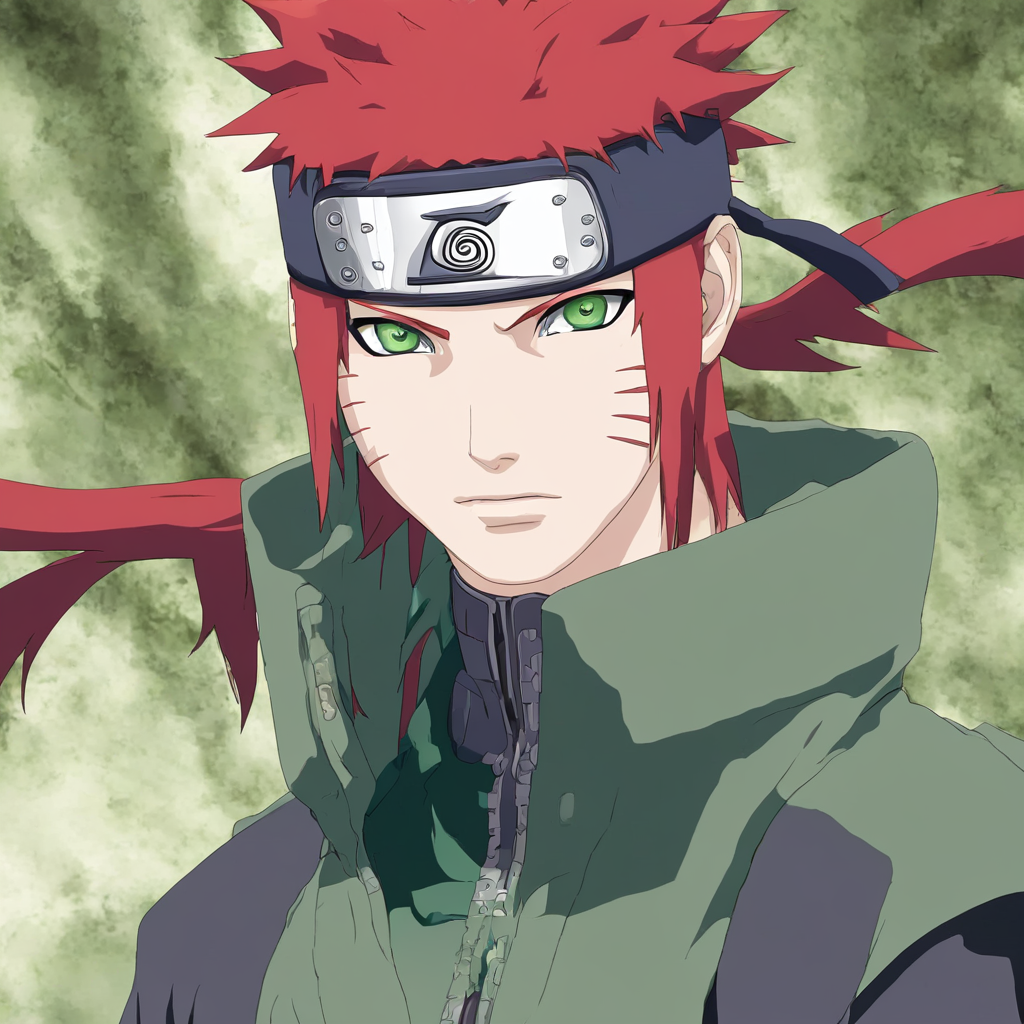

In [14]:
# Generate an image with trained model
prompt = "a naruto anime character with red hair and green eyes"
negative_prompt = "low quality, worst quality, bad anatomy, bad composition, poor, low effort"

# Generate image
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

# Display the result
image